In [1]:
import geopandas
import requests
import datetime
import calendar
import os

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px

from matplotlib.colors import  Normalize
from google.cloud import bigquery
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
CACHE_DIRECTORY = 'data/cache'

# You can get google application credenitals from https://console.cloud.google.com
GOOGLE_CREDENTIALS = '/Users/sahin/.google/google-key.json' # path/to/google/credentials

In [3]:
# Functions

# generates url for specific location to get sunset and sunrise data from "api.sunrisesunset.io"
# takes latitude, longitude and date 
# returns url
def url_generator(lat, lon, date):
    url = f'https://api.sunrisesunset.io/json?lat={str(lat)}&lng={str(lon)}&timezone=UTC&date={date}'
    return url


# gets geographic center point of a city in Turkey from "data.humdata.org"
# takes name of the city
# returns latitude and longitude
def get_tr_city_cp(city):
    humdata_file = 'data/humdata/tur_central_points/tur_pntcntr_adm1.shp'
    turkey_centeralpoints = geopandas.read_file(humdata_file)[['adm1_en', 'latitude', 'longitude']]
    turkey_centeralpoints = turkey_centeralpoints.rename(columns={'adm1_en': 'city'})
    
    [lat, long] = turkey_centeralpoints[turkey_centeralpoints['city'] == city][['latitude', 'longitude']].iloc[0]

    return lat, long


# converts time to minutes 
# takes time
# returns total minutes
def total_mins(time):
    s = datetime.timedelta(hours = time.hour,
                            minutes = time.minute)
    mins = s.total_seconds() / 60
    return mins


# generates a dataframe with columns of daily sunrise, sunset, and solar_moon times for the year 2023 (it has 265 days)
# takes name of the city
# returns dataframe
def get_sunset_sunrise(city, dst_mode, year=2023):
    os.makedirs(CACHE_DIRECTORY, exist_ok=True)

    cache_file = os.path.join(CACHE_DIRECTORY, f'{city.lower()}_sun_times_mode{dst_mode}_cache.csv')

    if os.path.isfile(cache_file):
        df = pd.read_csv(cache_file, parse_dates=['date'])
        return df

    columns = ['date', 'sunrise', 'sunset', 'solar_noon', 'sunrise(minutes)', 'sunset(minutes)', 'solar_noon(minutes)']
    data_frames = []

    if dst_mode==0: # permanent dst
        summer_diff = 3
        winter_diff = 3
    if dst_mode==1: # permanent standard time
        summer_diff = 2
        winter_diff = 2
    elif dst_mode==2: # dst for summer, standard time for winter
        summer_diff = 3
        winter_diff = 2

    start_date = datetime.date(year, 1, 1)
    end_date = datetime.date(year, 12, 31)
    dst_start_date = datetime.date(year, 3, 26) # last sunday of March 2023
    dst_end_date =  datetime.date(year, 10, 29) # last sunday of October 2023

    city_lat, city_long = get_tr_city_cp(city)

    delta = datetime.timedelta(days=1)
    while start_date <= end_date:
        date_url = url_generator(city_lat, city_long, f'{start_date.year}-{start_date.month}-{start_date.day}')
        req = requests.get(date_url).json()['results']

        sunrise = req['sunrise']
        sunset = req['sunset']
        solarnoon = req['solar_noon']

        date = datetime.datetime(start_date.year, start_date.month, start_date.day)
        sunrise = datetime.datetime.strptime(sunrise[:-3], '%H:%M:%S') 
        sunset = datetime.datetime.strptime(sunset[:-3], '%H:%M:%S')
        solarnoon = datetime.datetime.strptime(solarnoon[:-3], '%H:%M:%S')

        if start_date >= dst_start_date and start_date < dst_end_date:
            sunrise += datetime.timedelta(hours=summer_diff)
            sunset += datetime.timedelta(hours=12+summer_diff)
            solarnoon += datetime.timedelta(hours=summer_diff)
        else:
            sunrise += datetime.timedelta(hours=winter_diff)
            sunset += datetime.timedelta(hours=12+winter_diff)
            solarnoon += datetime.timedelta(hours=winter_diff)
        

        sunrise_mins = total_mins(sunrise)
        sunset_mins = total_mins(sunset)
        solarnoon_mins = total_mins(solarnoon)

        new_row = pd.DataFrame([[date, sunrise, sunset, solarnoon, sunrise_mins, sunset_mins, solarnoon_mins]],
                               columns=columns)

        data_frames.append(new_row)
        start_date += delta

    # Concatenate all DataFrames outside the loop
    df = pd.concat(data_frames, ignore_index=True)

    df.to_csv(cache_file, index=False)

    return df

# visualizes the annual sunrise, sunset, and solar_noon times for a specific city in Turkey
# takes name of the city and subplot ax
def plot_sunrise_sunset(city, dst_mode, ax):
    df = get_sunset_sunrise(city, dst_mode)

    ax.plot(np.arange(0, 365), df['sunrise(minutes)'], label='sunrise')
    ax.plot(np.arange(0, 365), df['sunset(minutes)'], label='sunset')
    ax.plot(np.arange(0, 365), df['solar_noon(minutes)'], label='solar_noon')

    ax.axhline(y=7*60, color='red', linewidth=3, label='7:00 a.m.')

    ax.grid()

    ax.set_ylabel('Time')
    ax.set_title(city, fontsize = 20)
    ax.legend()

    ax.set_xticks(np.arange(0, 365, step=31))
    ax.set_xticklabels(calendar.month_name[1:], rotation=30)

    ax.set_yticks(np.arange(0, 24*60, step=60*2))
    ax.set_yticklabels(np.arange(0, 24, step=2))


# generates one year data of daily traffic accidents in US as dataframe  
# takes year (2015 or 2016)
# returns dataframe
def get_us_accidents_data_by_year(year):
    s = f'bigquery-public-data.nhtsa_traffic_fatalities.accident_{year}'
    query = f'''
        SELECT COUNT(consecutive_number) AS accidentsCount,
               EXTRACT(DAY FROM timestamp_of_crash) AS day,
               EXTRACT(MONTH FROM timestamp_of_crash) AS month,
               EXTRACT(YEAR FROM timestamp_of_crash) AS year,   
               EXTRACT(DATE FROM timestamp_of_crash) AS date,
               EXTRACT(DAYOFWEEK FROM timestamp_of_crash) AS weekday
        FROM `{s}`
        GROUP BY date, year, month, day, weekday
        ORDER BY date
        '''

    client = bigquery.Client()

    query_job = client.query(query)
    accidents_by_date = query_job.to_dataframe()

    return accidents_by_date


# generates a new dataframe for a specific day from the given dataframe
# takes dataframe, day and month (or whole date)
# returns dataframe for 
def get_data_by_date(df, day = 1, month = 1, date = ''):
    if date != '':
        day, month, year = [int(x) for x in date.split('-')]

    data_by_date = (df[(df['day'] == day) &
                       (df['month'] == month)])

    return data_by_date


# visualizes the annual number of accidents in the US for a given year
# takes subplots ax and year
def plot_accidents_by_date(ax, year):
    if year == 2015:
        accidents = get_us_accidents_data_by_year(2015)
        # 8 Mar 2015 - Daylight Saving Time Started
        dst_started = get_data_by_date(accidents, day=8+1, month=3)
        # 1 Nov 2015 - Daylight Saving Time Ended
        dst_ended = get_data_by_date(accidents, day=1+1, month=11)
    elif year == 2016:
        accidents = get_us_accidents_data_by_year(2016)
        # 13 Mar 2016 - Daylight Saving Time Started
        dst_started = get_data_by_date(accidents, day=13+1, month=3)
        # 6 Nov 2016 - Daylight Saving Time Ended
        dst_ended = get_data_by_date(accidents, day=6+1, month=11)

    monday_mean = accidents[accidents['weekday'] == 2]['accidentsCount'].mean()
        
    ax.plot(accidents.index, accidents['accidentsCount'])
    ax.scatter(dst_started.index,
               dst_started['accidentsCount'],
               color='green',
               s = 150,
               label='Monday after dst started')
    ax.scatter(dst_ended.index,
               dst_ended['accidentsCount'],
               color='red',
               s = 150,
               label='Monday after dst ended')
    ax.axhline(y=monday_mean,
               color='black',
               label = 'Monday mean')

    ax.set_ylabel('Number of accidents')
    ax.set_title(f'US Traffic Accidents ({year})',
                 fontweight = 'bold',
                 fontsize = 20)
    ax.set_xticks(np.arange(0, 365, step=31))
    ax.set_xticklabels(calendar.month_name[1:], rotation=30, fontsize=17)
    ax.legend(fontsize=15)


# visualizes the average number of accidents according to the weekdays using a bar chart
# takes subplots ax and year
def plot_weekday_means(ax, year):
    weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    accidents = get_us_accidents_data_by_year(year)
    means = accidents.groupby('weekday',  as_index=False)['accidentsCount'].mean()

    ax.bar(weekdays, means['accidentsCount'])
    ax.set_title(f'Number of accidents by weekday ({year})')
    ax.set_ylabel('Number of accidents')

    ax.set_xticks(range(len(weekdays)))
    ax.set_xticklabels(weekdays, fontsize=12, rotation=30) 

# generates quantiles of the number of accidents that occur on Monday's for a given year
# takes year and quantiles
# returns a dataframe with quantiles
def monday_accidents_quantiles(year, quantiles):
    accidents = get_us_accidents_data_by_year(year)
    monday_accidents = accidents[accidents["weekday"] == 2]

    quantiles_df = monday_accidents[['accidentsCount']].quantile(quantiles)

    return quantiles_df

def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('stop')
    else:
        print('continue')

## Analysis of Turkey's Decision to Stay Permanently in Summer Time 

In 2016 Turkey decided to remain permanently in the summertime. Although some studies (["Daylight Saving Time policy and energy consumption, Sinan Küfeoğlu et al."](https://www.sciencedirect.com/science/article/pii/S2352484721006272#fig2)) have shown that daylight saving time is unnecessary, this decision was highly criticized by the public. Turkey's decision to remain permanently in the summertime has also been highly criticized because, considering the location of Turkey, it would be more logical to choose Normal Time permanently. Let's analyze and decide which timezone (dst or normal time) is better to remain permanently for Turkey.

### Turkey Population Density Map


In [4]:
tuik_file = 'data/tuik/il_nufus.xls'
tuik_pop = pd.read_excel(tuik_file)

In [5]:
turkey_2022_pop = tuik_pop.iloc[4:85, [0, 23]].reset_index(drop = True)
turkey_2022_pop.columns = ['city', 'population']

In [6]:
turkey_2022_pop['city'] = turkey_2022_pop['city'].apply(lambda city : city.upper())
turkey_2022_pop['city'] = turkey_2022_pop['city'].str.replace('Ç', 'C')
turkey_2022_pop['city'] = turkey_2022_pop['city'].str.replace('Ğ', 'G')
turkey_2022_pop['city'] = turkey_2022_pop['city'].str.replace('İ', 'I')
turkey_2022_pop['city'] = turkey_2022_pop['city'].str.replace('Ö', 'O')
turkey_2022_pop['city'] = turkey_2022_pop['city'].str.replace('Ş', 'S')
turkey_2022_pop['city'] = turkey_2022_pop['city'].str.replace('Ü', 'U')

In [7]:
humdata_file = 'data/humdata/tur_boundaries/tur_polbnda_adm1.shp'
turkey_adm = geopandas.read_file(humdata_file)[['adm1_en', 'geometry']]
turkey_adm = turkey_adm.rename(columns={'adm1_en': 'city'})

In [8]:
turkey_pop_geo = pd.merge(turkey_adm, turkey_2022_pop)

On this heatmap, we see the population density of cities in Turkey.

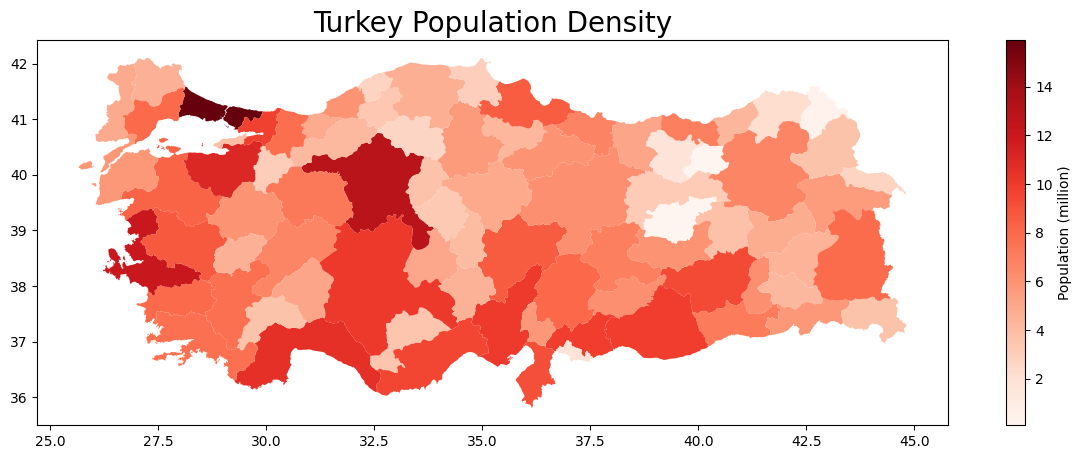

In [9]:
turkey_pop_geo['population(log())'] = np.log(turkey_pop_geo['population'])

fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Turkey Population Density", size=20)
turkey_pop_geo.plot(column="population(log())", cmap="Reds", ax=ax)
n = Normalize(turkey_pop_geo.population.min()/1000000, turkey_pop_geo.population.max()/1000000)
cbar = plt.cm.ScalarMappable(norm=n, cmap="Reds")
ax_cbar = fig.colorbar(cbar, ax=ax)
ax_cbar.set_label("Population (million)")

### Population and Geographical Center Points of Turkey

Let's calculate the geographical and population center points of Turkey and analyze which meridian these points are closer to.

In [10]:
humdata_file2 = 'data/humdata/tur_central_points/tur_pntcntr_adm1.shp'
turkey_centeralpoints = geopandas.read_file(humdata_file2)[['adm1_en', 'latitude', 'longitude']]
turkey_centeralpoints = turkey_centeralpoints.rename(columns={'adm1_en': 'city'})

In [11]:
turkey_pop_lot_long = pd.merge(turkey_centeralpoints, turkey_2022_pop)

In [12]:
turkey_total_pop = turkey_2022_pop['population'].sum()

In [13]:
pop_cp_lat = np.sum(turkey_pop_lot_long['latitude']*turkey_pop_lot_long['population'])/turkey_total_pop
pop_cp_long = np.sum(turkey_pop_lot_long['longitude']*turkey_pop_lot_long['population'])/turkey_total_pop

df = pd.DataFrame({'latitude': [pop_cp_lat],'longitude': [pop_cp_long]})

pop_cp = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.longitude, df.latitude))

In [14]:
geo_cp_lat = (min(turkey_pop_lot_long['latitude']) + max(turkey_pop_lot_long['latitude'])) / 2
geo_cp_long = (min(turkey_pop_lot_long['longitude']) + max(turkey_pop_lot_long['longitude'])) / 2

df = pd.DataFrame({'latitude': [geo_cp_lat],'longitude': [geo_cp_long]})

geo_cp = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.longitude, df.latitude))

We can see that the population center point is clearly close to the 30th meridian, while the geopraghical center point is located in the middle of the two meridians (slightly closer to the 40th meridian).

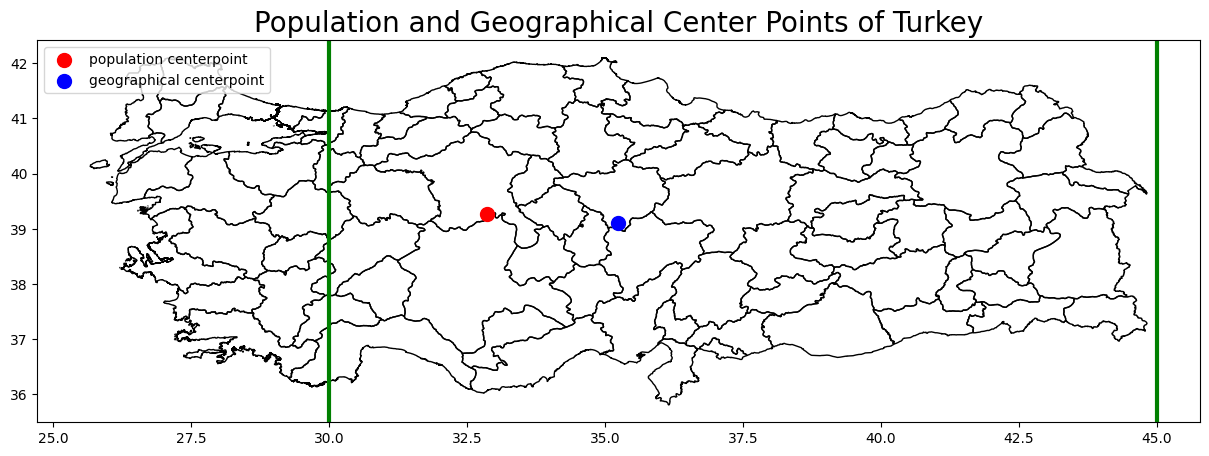

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))

turkey_adm.plot(ax = ax,edgecolor="k", facecolor="none")
pop_cp.plot(ax = ax, color='red', markersize = 100, label='population centerpoint')
geo_cp.plot(ax = ax, color='blue', markersize = 100, label='geographical centerpoint')
ax.axvline(x=30, color='green', linewidth=3)
ax.axvline(x=45, color='green', linewidth=3)

ax.set_title("Population and Geographical Center Points of Turkey", size=20)
ax.legend()

plt.show()

### Which cities are worst affected by the permanent summertime in Turkey?
Cities in the west will be most affected by the permanent summertime. We can find these cities by looking at the longitudes of the city center points. In winter, people in these cities wake up about an hour before sunrise and go to work or school.

In [16]:
turkey_centeralpoints['cpDistanceMeridian45'] = abs(turkey_centeralpoints['longitude']-45)
turkey_centeralpoints['cpDistanceMeridian30'] = abs(turkey_centeralpoints['longitude']-30)

Top 5 most affected cities:

In [17]:
turkey_centeralpoints.sort_values(by='cpDistanceMeridian45', ascending=False)[:5]

,city,latitude,longitude,cpDistanceMeridian45,cpDistanceMeridian30
21,CANAKKALE,40.146498,26.406294,18.593706,3.593706
27,EDIRNE,41.676425,26.552412,18.447588,3.447588
40,IZMIR,38.434144,27.171866,17.828134,2.828134
49,KIRKLARELI,41.735924,27.218857,17.781143,2.781143
55,MANISA,38.622270,27.433657,17.566343,2.566343


In [18]:
affected_df = pd.merge(turkey_adm, turkey_centeralpoints)

This is the map of the distances of the 40th meridian, which is taken as a basis in the permanent wintertime, to the cities. Considering that the population of the cities in the west is quite high, this is an important problem.

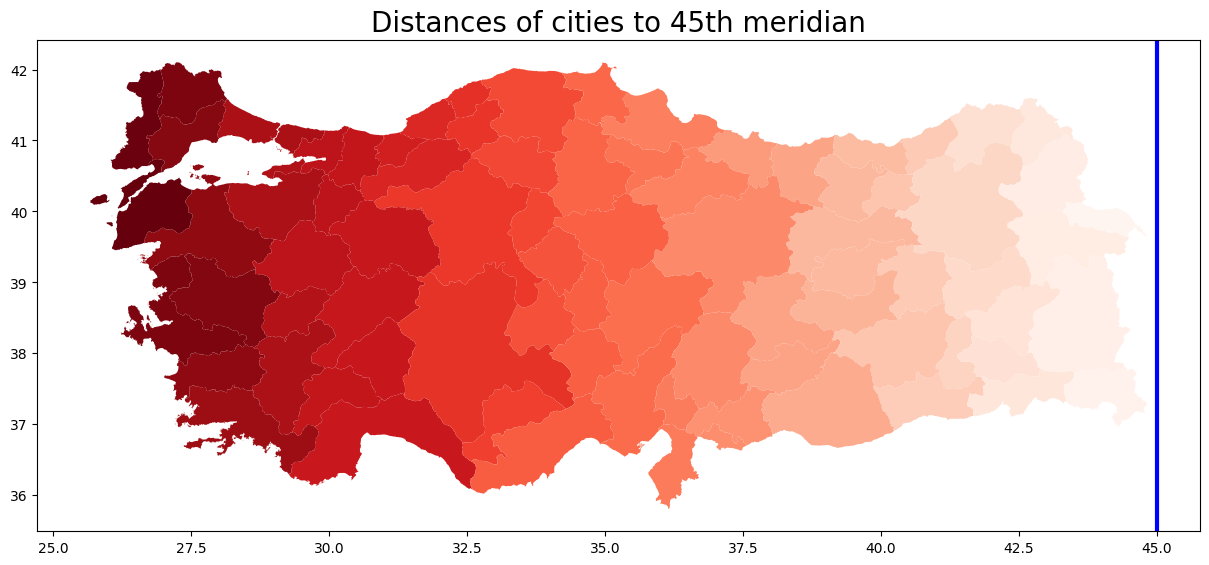

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Distances of cities to 45th meridian", size=20)
affected_df.plot(column='cpDistanceMeridian45', cmap="Reds", ax=ax)
ax.axvline(x=45, color='blue', linewidth=3)
plt.show()

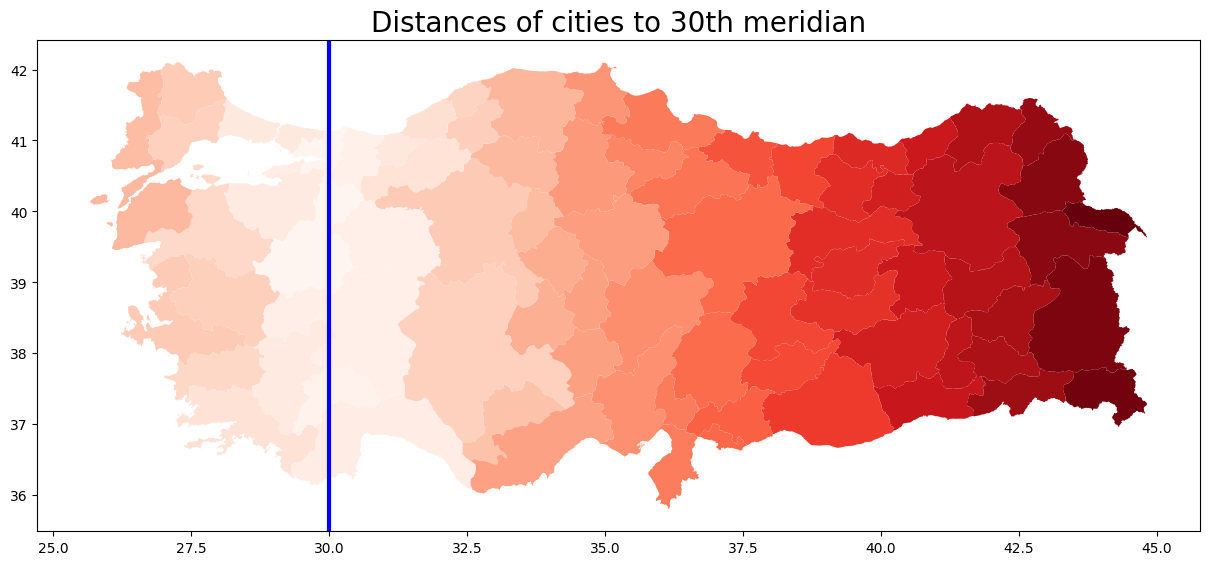

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Distances of cities to 30th meridian", size=20)
affected_df.plot(column='cpDistanceMeridian30', cmap="Reds", ax=ax)
ax.axvline(x=30, color='blue', linewidth=3)
plt.show()

### Preliminary results of the public consultation on time change in Europe (2018)
On 31 August 2018, the European Commission published the preliminary results of the public consultation on the time change. 

In [21]:
results = pd.DataFrame([['Austria', 0.77],
                        ['Belgium', 0.84],
                        ['Bulgaria', 0.84],
                        ['Croatia', 0.90],
                        ['Cyprus', 0.47],
                        ['Czechia', 0.83],
                        ['Denmark', 0.81],
                        ['Estonia', 0.85],
                        ['Finland', 0.95],
                        ['France', 0.84],
                        ['Germany', 0.84],
                        ['Greece', 0.44],
                        ['Hungary', 0.90],
                        ['Ireland', 0.88],
                        ['Italy', 0.66],
                        ['Latvia', 0.85],
                        ['Lithuania', 0.91],
                        ['Luxembourg', 0.79],
                        ['Malta', 0.54],
                        ['Netherlands', 0.79],
                        ['Poland', 0.95],
                        ['Portugal', 0.85],
                        ['Romania', 0.78],
                        ['Slovakia', 0.80],
                        ['Slovenia', 0.87],
                        ['Spain', 0.93],
                        ['Sweden', 0.88],
                        ['United Kingdom', 0.82]],
                        columns = ['country', 'abolish'])
results['keep'] = (1-results['abolish'])*100
results['abolish'] = results['abolish']*100

As seen here, almost all of the countries voted to abolish the daylight saving time.

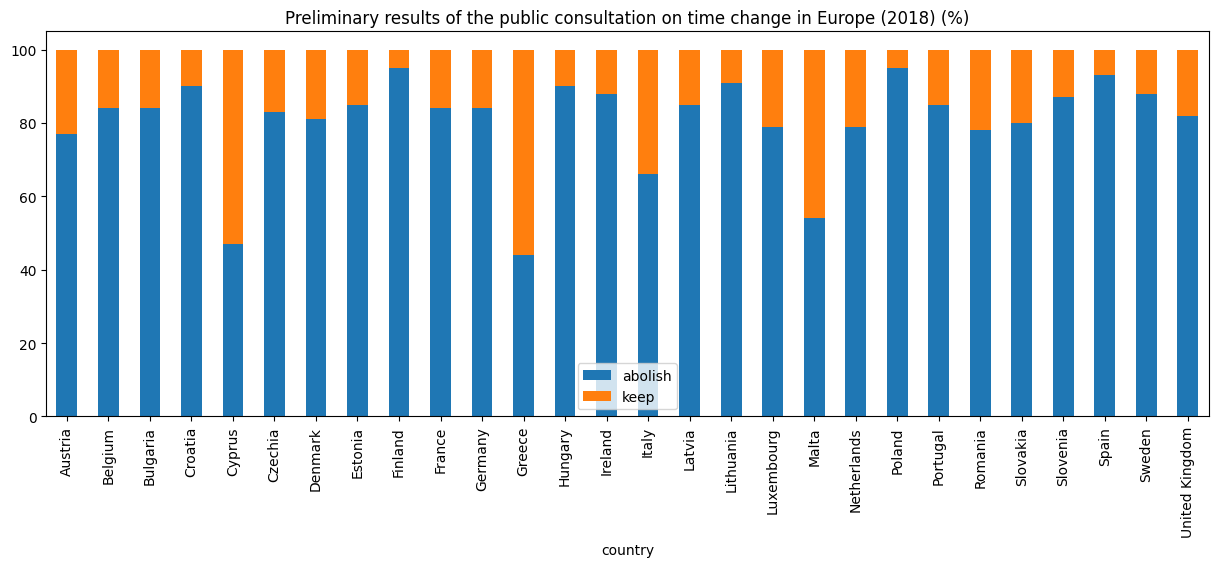

In [22]:
results.plot.bar(x = 'country', stacked='true', title='Preliminary results of the public consultation on time change in Europe (2018) (%)', figsize=(15, 5))
plt.show()

## Sunrise and Sunset Times for Cities in Turkey


* __Çanakkale__ -> western edge of Turkey
* __Iğdır__ -> eastern edge of Turkey
* __Istanbul__ -> the most crowded city in Turkey
* __Ankara__ -> the capital of Turkey, also the population center point is in Ankara 

As seen below, the sun rises later in cities in the west. I showed 7:00 a.m. with a red line for every city.

### Sunrise and Sunset times with permanent DST (current decision): 

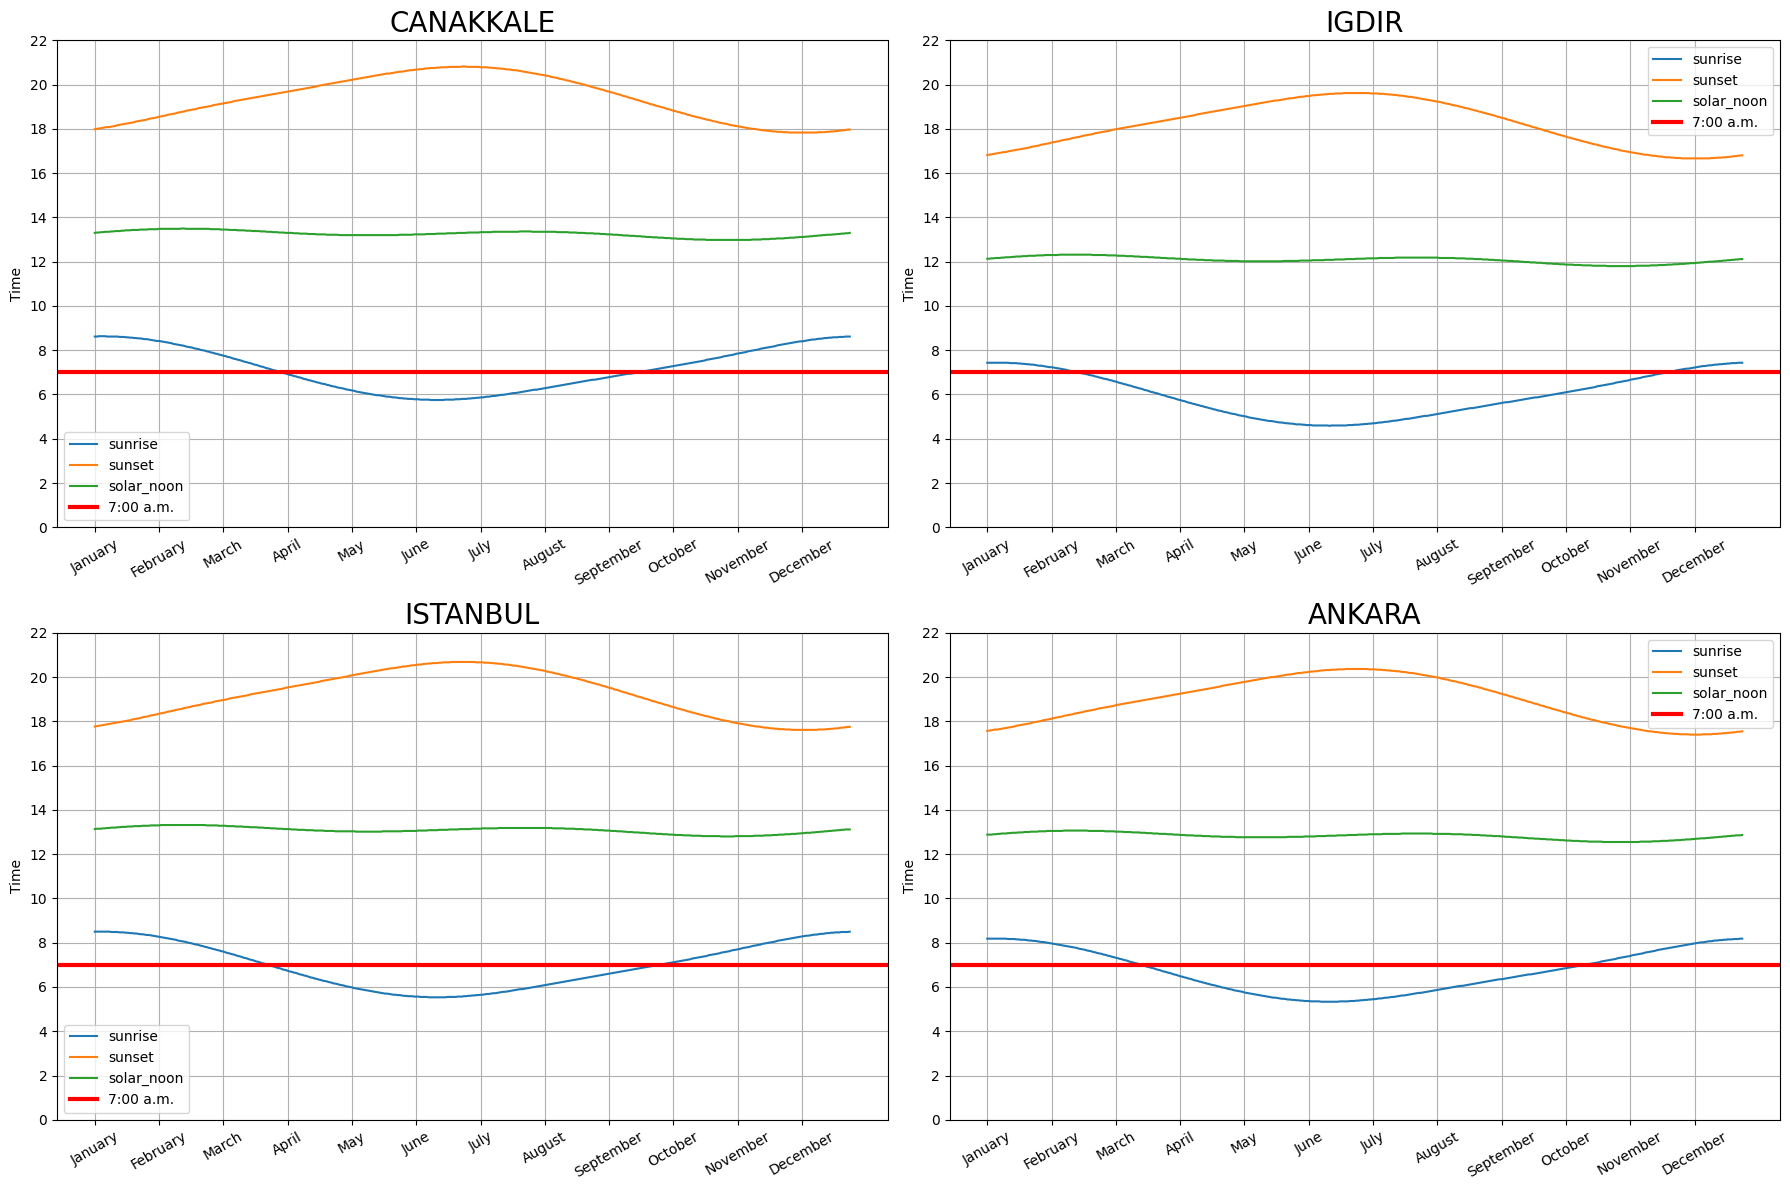

In [23]:
cities = ['CANAKKALE', 'IGDIR', 'ISTANBUL', 'ANKARA']
x, y = 0, 0

fig, axs = plt.subplots(2, 2, figsize=(18,12))

for city in cities:
    if(y==2):
        y=0
        x+=1
    plot_sunrise_sunset(city, 0, axs[x, y])
    y += 1

fig.tight_layout()

plt.show()

### If Türkiye adopts permanent standard time:

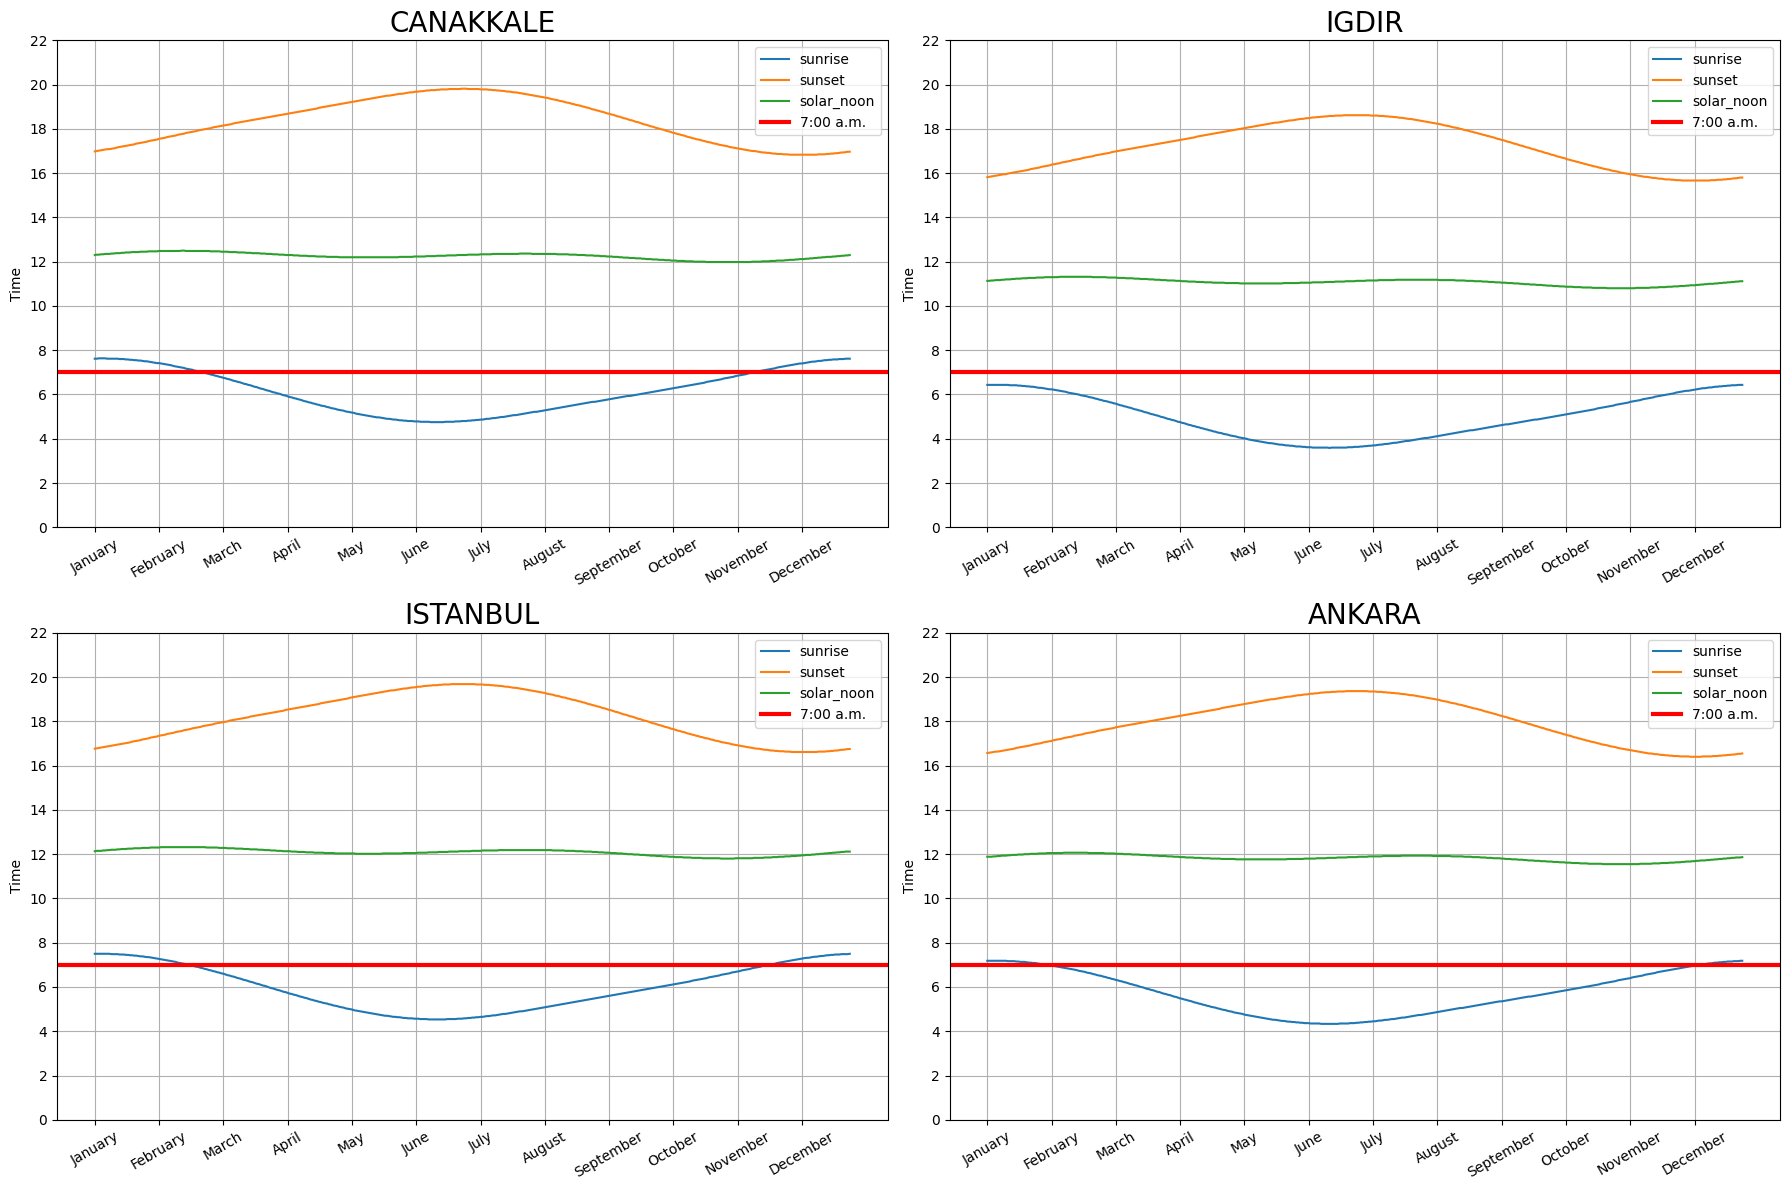

In [24]:
cities = ['CANAKKALE', 'IGDIR', 'ISTANBUL', 'ANKARA']
x, y = 0, 0

fig, axs = plt.subplots(2, 2, figsize=(18,12))

for city in cities:
    if(y==2):
        y=0
        x+=1
    plot_sunrise_sunset(city, 1, axs[x, y])
    y += 1

fig.tight_layout()

plt.show()

### If Türkiye adopts standard time for winter and DST for summer:

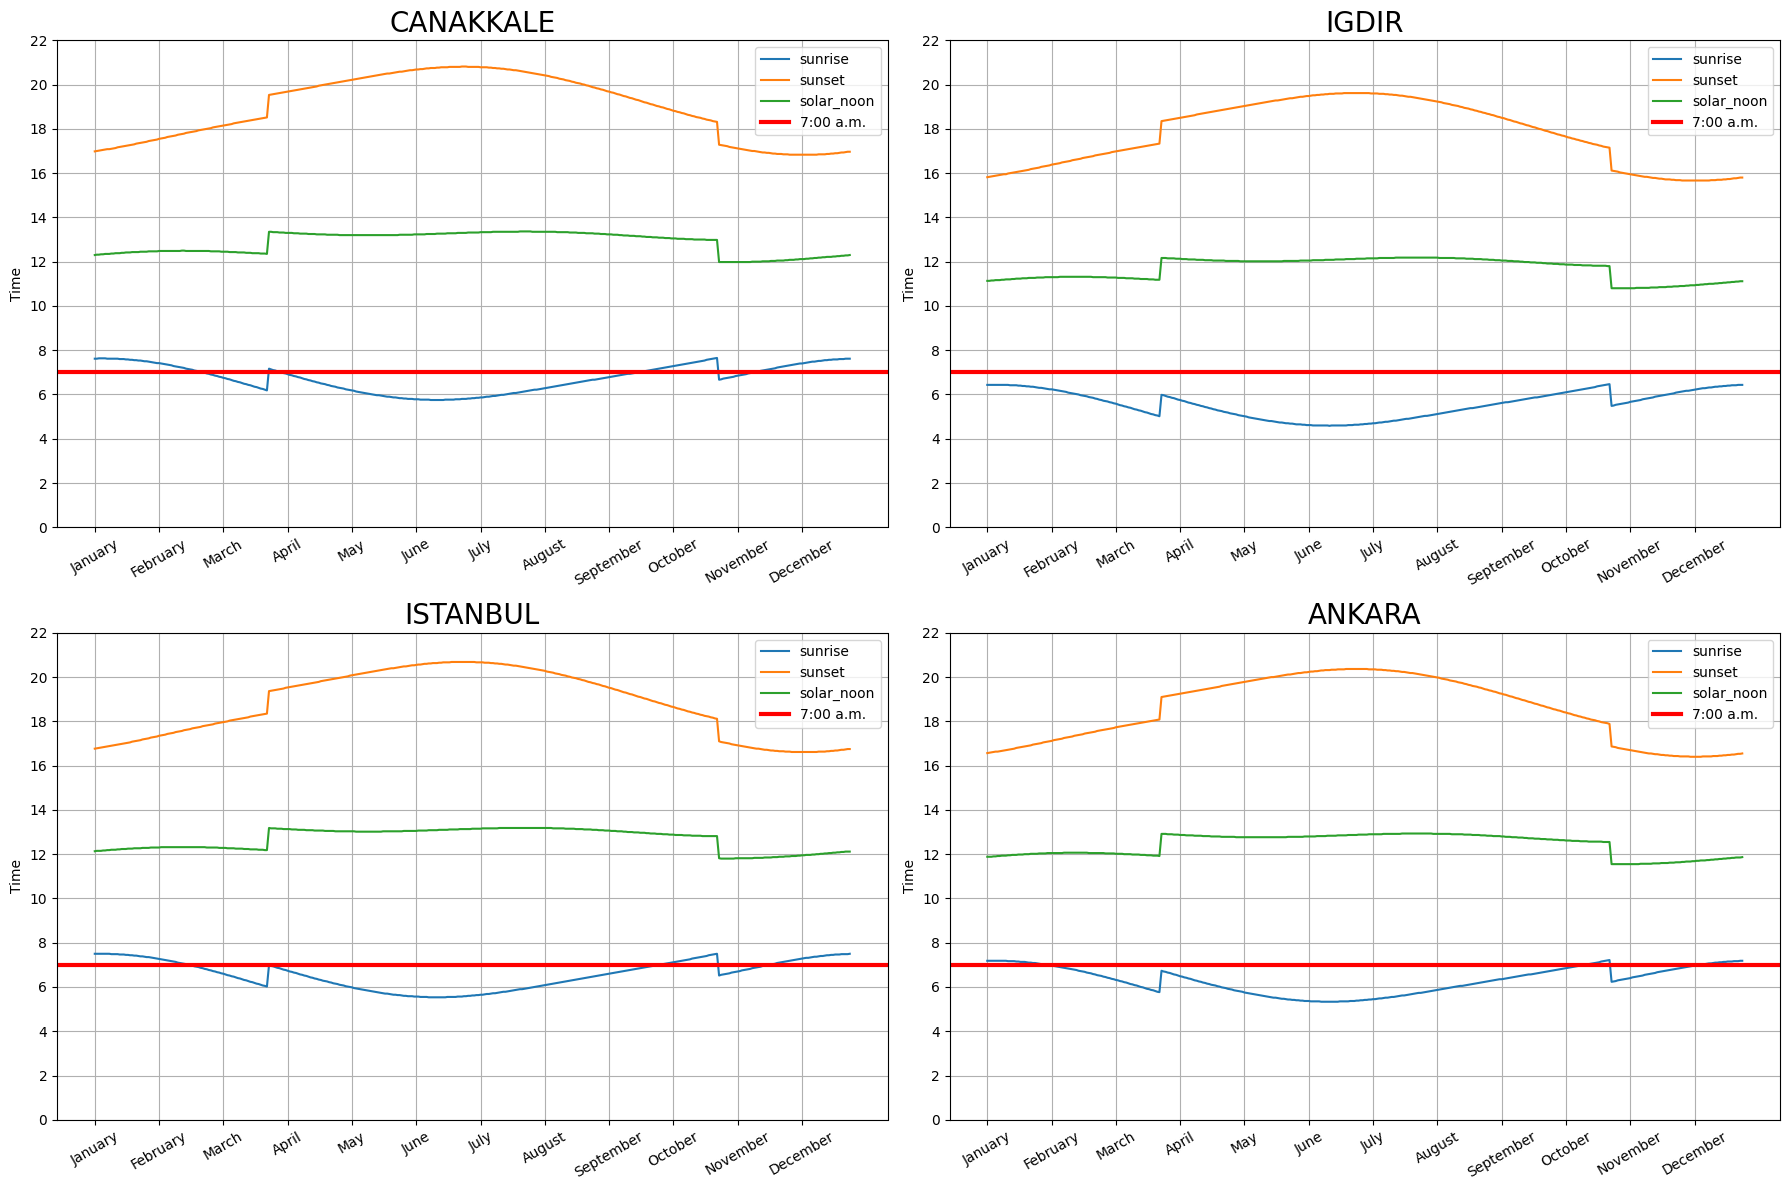

In [25]:
cities = ['CANAKKALE', 'IGDIR', 'ISTANBUL', 'ANKARA']
x, y = 0, 0

fig, axs = plt.subplots(2, 2, figsize=(18,12))

for city in cities:
    if(y==2):
        y=0
        x+=1
    plot_sunrise_sunset(city, 2, axs[x, y])
    y += 1

fig.tight_layout()

plt.show()

## Tétouan Energy Consumption and Daylight Saving Time

2017: 
* 26 March 2017 (Sunday) - Daylight Saving Time Started
* 21 May 2017 (Sunday) - Daylight Saving Time Ended
* 2 July 2017 (Sunday) - Daylight Saving Time Started
* 29 November 2017 (Sunday) - Daylight Saving Time Ended

There were 4 time changes in Morocco. This was because in 2017, the holy month of Ramadan overlapped with the period DST was implemented. During Ramadan, Morocco suspends DST to regulate fasting hours. Thus, in my analysis, I had the chance to observe four periods following each time change. 

In [26]:
tetouan_dir = "data/tetouan/electric-consumption-tetouan.csv"
tetouan_df = pd.read_csv(tetouan_dir)

tetouan_df = tetouan_df[0::6].reset_index(drop=True)
tetouan_df['Datetime'] = pd.to_datetime(tetouan_df['Datetime'])
tetouan_df['TotalConsumption'] = tetouan_df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].sum(axis=1)

In [27]:
dst1_start = datetime.date(2017, 3, 26)
dst1_end = datetime.date(2017, 5, 21)
dst2_start = datetime.date(2017, 7, 2)
dst2_end = datetime.date(2017, 10, 29)

tetouan_df['dst'] = 0

tetouan_df.loc[(tetouan_df['Datetime'].dt.date >= dst1_start) & (tetouan_df['Datetime'].dt.date <= dst1_end), 'dst'] = 1
tetouan_df.loc[(tetouan_df['Datetime'].dt.date >= dst2_start) & (tetouan_df['Datetime'].dt.date <= dst2_end), 'dst'] = 1

tetouan_df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,TotalConsumption,dst
0,2017-01-01 00:00:00,6.559,73.80,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,70425.53544,0
1,2017-01-01 01:00:00,5.641,77.70,0.080,0.048,0.096,25998.98734,16993.31307,17945.06024,60937.36065,0
2,2017-01-01 02:00:00,5.059,78.60,0.081,0.070,0.096,23003.54430,15169.60486,16117.59036,54290.73952,0
3,2017-01-01 03:00:00,5.169,77.90,0.083,0.066,0.108,21107.84810,13535.56231,15140.24096,49783.65137,0
4,2017-01-01 04:00:00,4.753,75.70,0.083,0.044,0.134,20524.55696,12820.66869,14585.06024,47930.28589,0
...,...,...,...,...,...,...,...,...,...,...,...
8731,2017-12-30 19:00:00,9.920,61.15,0.073,0.062,0.096,37694.29658,32623.50414,16825.93037,87143.73109,0
8732,2017-12-30 20:00:00,9.020,63.38,0.075,0.048,0.130,37146.76806,32373.12059,16941.17647,86461.06512,0
8733,2017-12-30 21:00:00,8.800,65.49,0.082,0.088,0.115,36343.72624,31345.81160,16877.79112,84567.32896,0
8734,2017-12-30 22:00:00,8.090,68.49,0.079,0.070,0.085,34920.15209,29445.84228,16053.78151,80419.77588,0


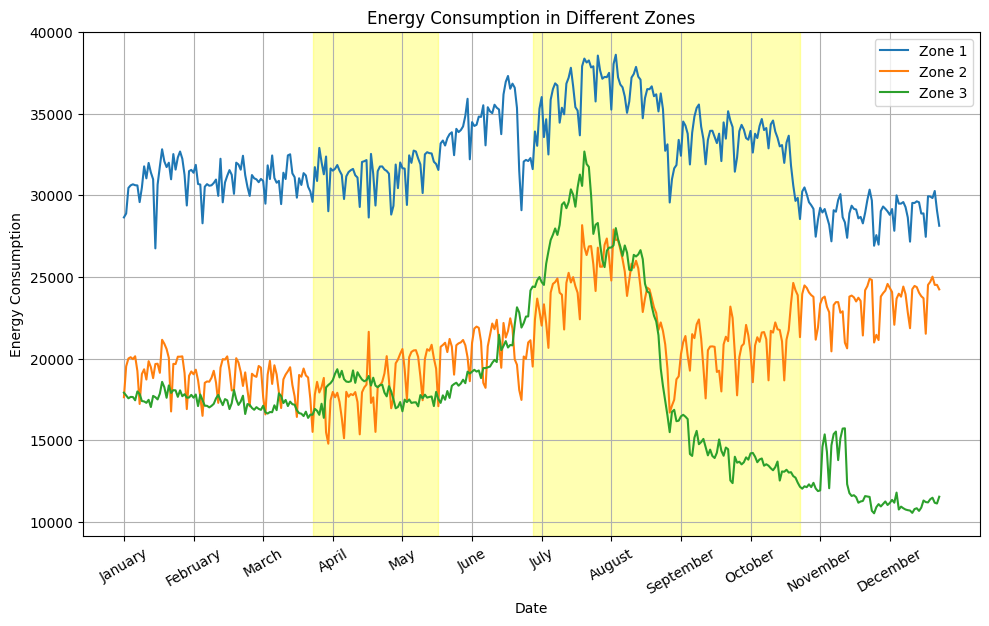

In [28]:
day_count = len(tetouan_df) // 24

daily_avg_zone1 = tetouan_df['PowerConsumption_Zone1'].values.reshape(day_count, 24).mean(axis=1)
daily_avg_zone2 = tetouan_df['PowerConsumption_Zone2'].values.reshape(day_count, 24).mean(axis=1)
daily_avg_zone3 = tetouan_df['PowerConsumption_Zone3'].values.reshape(day_count, 24).mean(axis=1)

plt.figure(figsize=(10, 6))
ax = plt.gca()

plt.plot(np.arange(day_count), daily_avg_zone1, label='Zone 1')
plt.plot(np.arange(day_count), daily_avg_zone2, label='Zone 2')
plt.plot(np.arange(day_count), daily_avg_zone3, label='Zone 3')

plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption in Different Zones')
plt.legend()
plt.grid(True)
plt.tight_layout()

ax.set_xticks(np.arange(0, day_count, step=31))
ax.set_xticklabels(calendar.month_name[1:], rotation=30)

time_changes = [("2017-03-26 02:00:00", "2017-05-21 03:00:00"), 
                ("2017-07-02 02:00:00", "2017-10-29 03:00:00")]

for start_date, end_date in time_changes:
    start_index = tetouan_df[tetouan_df['Datetime'] == start_date].index[0] // 24
    end_index = tetouan_df[tetouan_df['Datetime'] == end_date].index[0] // 24
    ax.axvspan(start_index, end_index, color='yellow', alpha=0.3)

plt.show()

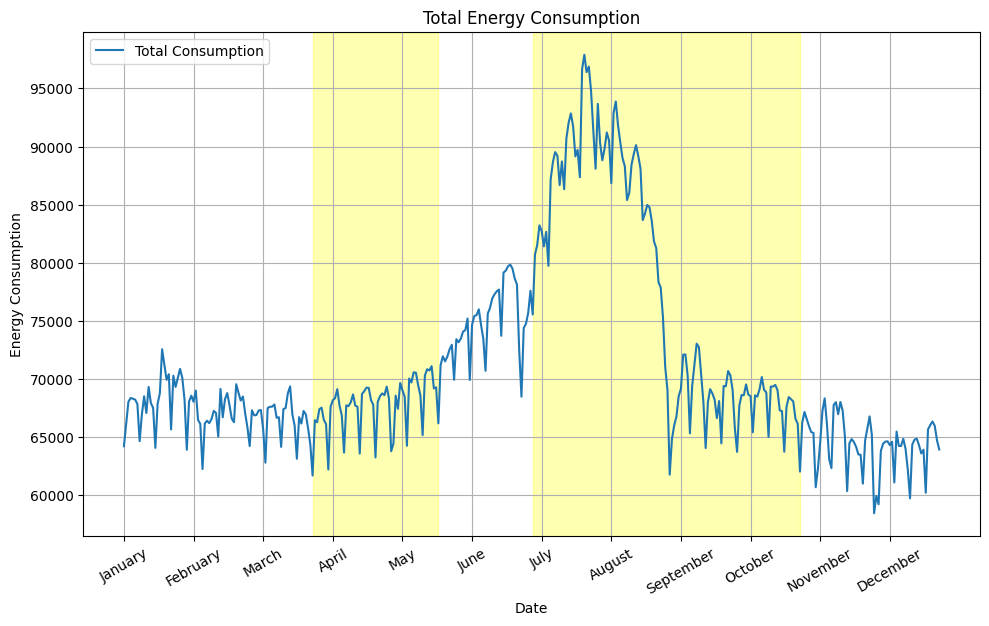

In [29]:
daily_avg_all_zones = tetouan_df['TotalConsumption'].values.reshape(day_count, 24).mean(axis=1)

plt.figure(figsize=(10, 6))
ax = plt.gca()

plt.plot(np.arange(day_count), daily_avg_all_zones, label='Total Consumption')

plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Total Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()

ax.set_xticks(np.arange(0, day_count, step=31))
ax.set_xticklabels(calendar.month_name[1:], rotation=30)

for start_date, end_date in time_changes:
    start_index = tetouan_df[tetouan_df['Datetime'] == start_date].index[0] // 24
    end_index = tetouan_df[tetouan_df['Datetime'] == end_date].index[0] // 24
    ax.axvspan(start_index, end_index, color='yellow', alpha=0.3)

plt.show()

My dataset includes energy consumption, temperature, wind speed, humidity data, general diffuse flow, and diffuse flow along with a dummy DST variable that I added later. To create a similar Ordinary Least Squares (OLS) regression model with multiple independent variables, I carefully selected the variables to include. Upon, examining the correlation matrix (see below), I identified multicollinearity among general diffuse flows, diffuse flows, and temperature. Furthermore, the strongest correlation was between DST and temperature, which was expected since the DST change occurred in summer.

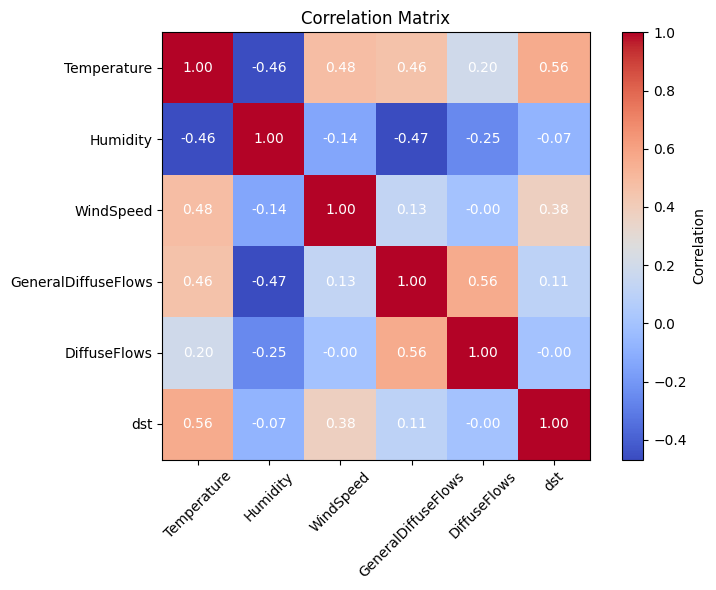

In [30]:
correlation_matrix = tetouan_df[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'dst']].corr()

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')

for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='white')

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.tight_layout()

plt.show()

After the interpretation of the correlation matrix, I decided to include energy consumption, temperature, wind speed, humidity, and DST variables into my first model. The model's representation:

<div style="text-align: center;">

$y=a+ β_{Temp} X_1+ β_{Wind} X_2+ β_{Humidty} X_3+ β_{Intersection} X_4+ β_{dst} X_5$

</div>

To understand the effect of the dst variable to R-squared value in my model. I created another model without using the dst variable. The representation of the model is given below 

<div style="text-align: center;">

$y=a+ β_{Temp} X_1+ β_{Wind} X_2+ β_{Humidty} X_3+ β_{Intersection} X_4$

</div>


These models are for total energy consumption, which is the sum of the consumption of zone-1, zone-2, and zone-3.

In [31]:
tetouan_df['const'] = 1

zones = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3', 'TotalConsumption']

results1 = {}
results2 = {}

for zone in zones:
    y = tetouan_df[zone]
    X1 = tetouan_df[['const', 'dst', 'Temperature', 'Humidity', 'WindSpeed']]
    X2 = tetouan_df[['const', 'Temperature', 'Humidity', 'WindSpeed']]

    model1 = sm.OLS(y, X1).fit()
    model2 = sm.OLS(y, X2).fit()

    results1[zone] = model1
    results2[zone] = model2

 The R-squared value is 0.253 for the first model. It is much less than 0.90, which is the acceptable boundary to say that my model can provide an accurate prediction. This indicates that while the model highlights significant relationships, it doesn’t capture all the independent variables affecting energy consumption.

In [32]:
print(f"Model Summary for {zones[3]}:")
results1[zones[3]].summary()

Model Summary for TotalConsumption:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TotalConsumption   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     738.8
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:49:22   Log-Likelihood:                -96271.
No. Observations:                8736   AIC:                         1.926e+05
Df Residuals:                    8731   BIC:                         1.926e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.959e+04   1270.206     39.038      0.000    4.71e+04    5.21e+04
dst         -3634.3043    398.857     -9.112      0.000   -4416.158   -2852.450
Temperature  1509.6429     40.568     37.213      0.000    1430.120    1589.166
Humidity      -75.8274     11.874     -6.386      0.000     -99.104     -52.551
WindSpeed      50.6360     77.768      0.651      0.515    -101.808     203.080
==============================================================================
Omnibus:                      467.279   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.553
Skew:                           0.597   Prob(JB):                    5.08e-117
Kurtosis:                       2.791   Cond. No.                         584.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We observe that the change (0.253 - 0.246 = 0.007) in R-squared value when the DST varriable is excluded from the model is relatively small. This indicates that while DST has an effect on energy consumption, its impact is not remarkable. Therefore, we conclude that the impact of the DST policy alone on energy consumption seems unlikely to be significant.

In [33]:
print(f"Model Summary for {zones[3]}:")
results2[zones[3]].summary()

Model Summary for TotalConsumption:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TotalConsumption   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     948.5
Date:                Wed, 12 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:49:22   Log-Likelihood:                -96312.
No. Observations:                8736   AIC:                         1.926e+05
Df Residuals:                    8732   BIC:                         1.927e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.336e+04   1206.561     44.222      0.000     5.1e+04    5.57e+04
Temperature  1319.0155     34.920     37.772      0.000    1250.564    1387.467
Humidity     -101.8674     11.579     -8.797      0.000    -124.566     -79.169
WindSpeed     -38.1873     77.516     -0.493      0.622    -190.137     113.763
==============================================================================
Omnibus:                      487.342   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              554.318
Skew:                           0.603   Prob(JB):                    4.28e-121
Kurtosis:                       2.741   Cond. No.                         549.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## US Traffic Accidents and Daylight Saving Time

* 2015: 
    * 8 March 2015 (Sunday) - Daylight Saving Time Started
    * 1 November 2015 (Sunday) - Daylight Saving Time Ended
* 2016:
    * 13 March 2016 (Sunday) - Daylight Saving Time Started
    * 6 November 2016 (Sunday) - Daylight Saving Time Ended

These dates show the days when the time changes for the daylight saving time were made.

In [34]:
# You can get google application credenitals from https://console.cloud.google.com
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_CREDENTIALS

Bar chart for the average number of accidents by weekdays for 2015 and 2016:

In [35]:
accidents_2015 = get_us_accidents_data_by_year(2015)
accidents_2016 = get_us_accidents_data_by_year(2016)

accidents = pd.concat([accidents_2015, accidents_2016])
accidents['date'] = pd.to_datetime(accidents['date'])
accidents.set_index('date', inplace=True)

accidents

,accidentsCount,day,month,year,weekday
date,,,,,
2015-01-01,105,1,1,2015,5
2015-01-02,65,2,1,2015,6
2015-01-03,95,3,1,2015,7
2015-01-04,52,4,1,2015,1
2015-01-05,79,5,1,2015,2
...,...,...,...,...,...
2016-12-27,85,27,12,2016,3
2016-12-28,85,28,12,2016,4
2016-12-29,87,29,12,2016,5


I made this interactive graph of traffic accident numbers to see the two years (2015 & 2016) together.

In [36]:
fig = px.line(accidents.reset_index(), x='date', y='accidentsCount', title='US Traffic Accidents (2015 & 2016)')

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='2y', step="year", stepmode="backward"),
        ])
    )
)

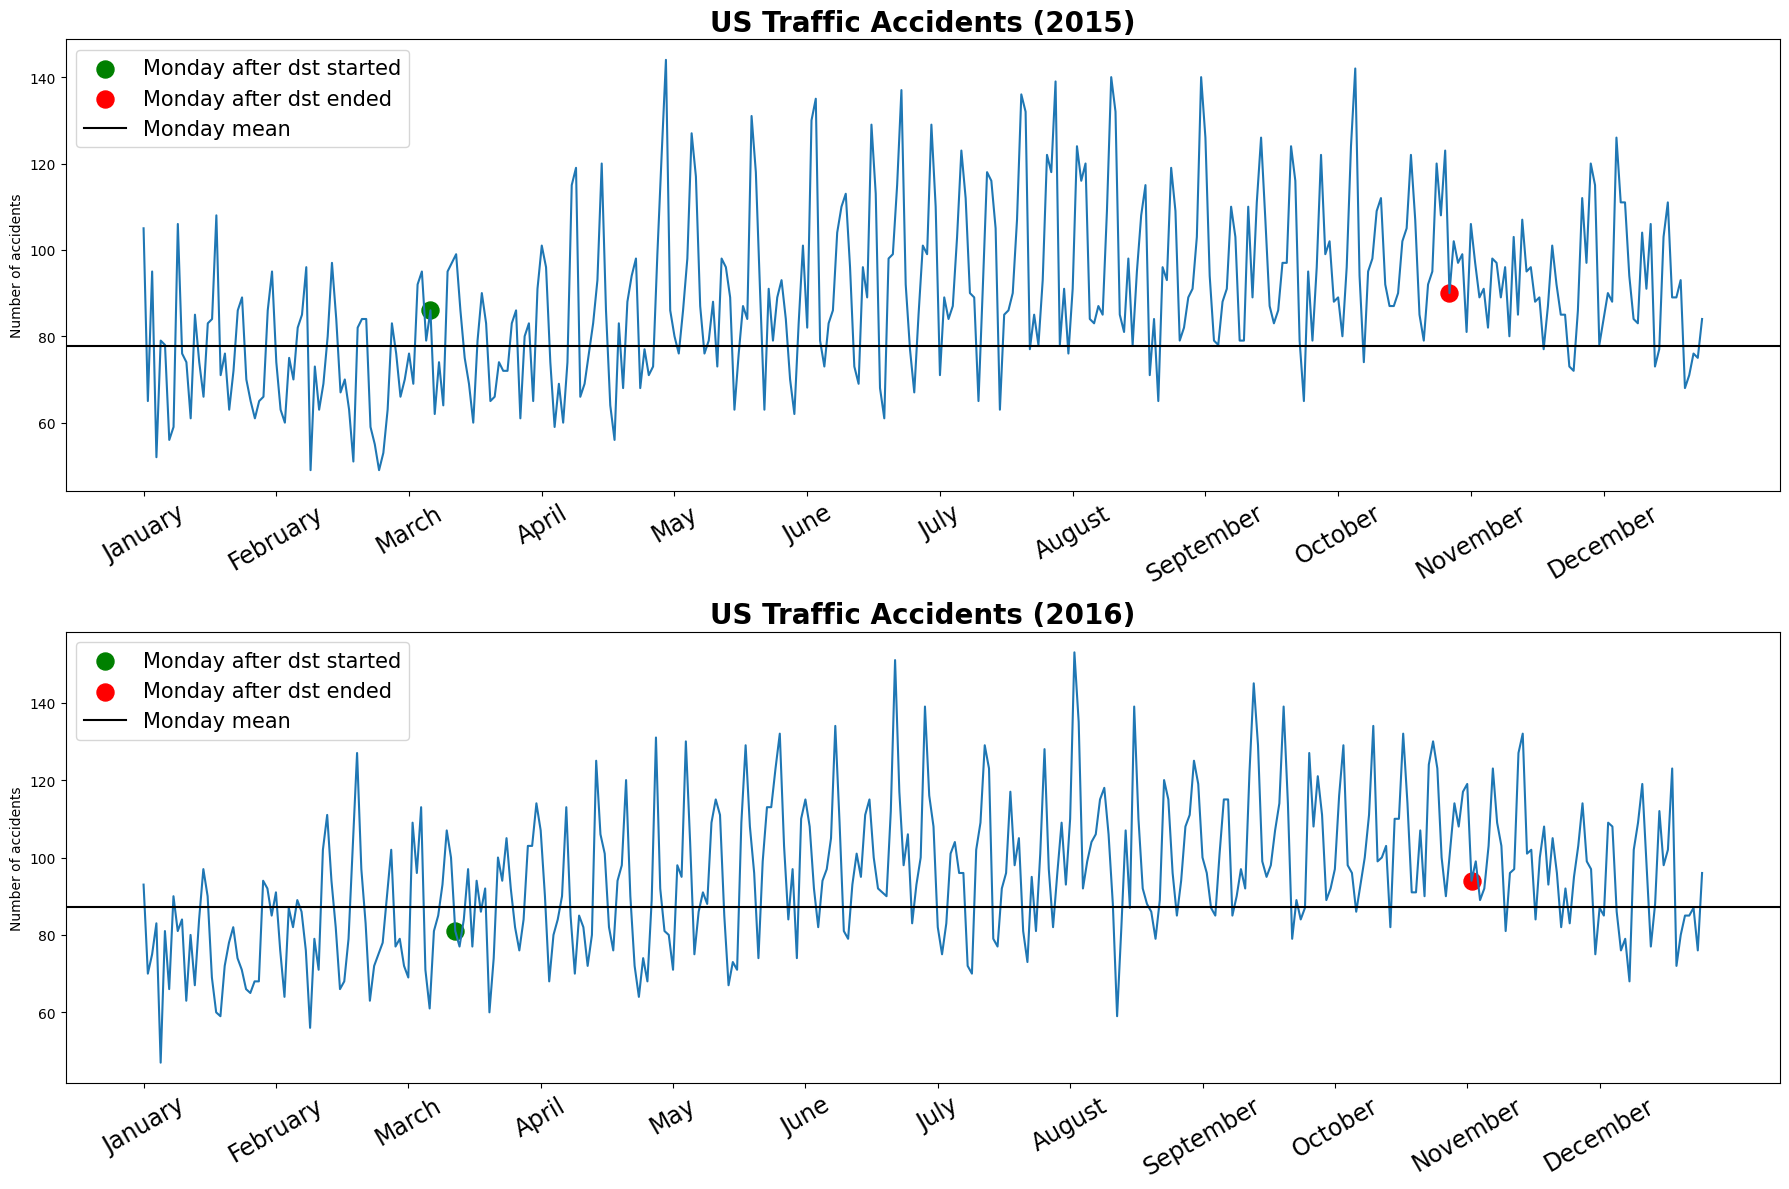

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(18,12))

plot_accidents_by_date(axs[0], year=2015)
plot_accidents_by_date(axs[1], year=2016)

fig.tight_layout()

plt.show()

I decided that using a time series forecasting model known as SARIMA (Seasonal Autoregressive Integrated Moving Average) for my analysis was the optimal choice since my data exhibit seasonal patterns, such as increased accidents throughout the week.

To build a SARIMA model we need to determine the values p, d and q for the autoregressive (AR) and moving average (MA) components, as well as the seasonal orders. Since we have a weekly pattern, the seasonal order is 7 (i.e. s=7).

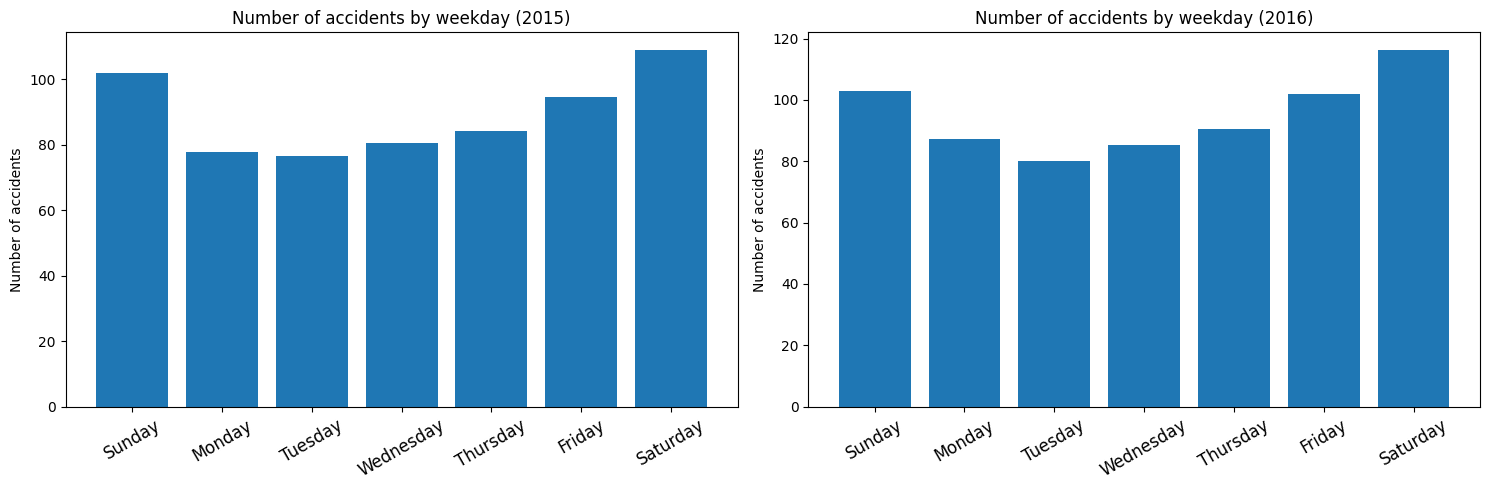

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_weekday_means(axs[0], year=2015)
plot_weekday_means(axs[1], year=2016)

fig.tight_layout()

plt.show()

To find the differencing order (d), we need to determine the number of times needed to differentiate the data to make it stationary. The data is initially non-stationary because the P-value of the Augmented Dickey-Fuller (ADF) test is larger than 0.05. 

In [39]:
adfuller_test(accidents['accidentsCount'])

ADF Test Statistic : -1.962846597216219
p-value : 0.30309729921863543
#Lags Used : 20
Number of Observations Used : 710
continue


We create a new column by taking the seasonal difference of the data, and then we continue differentiating it until the P-value is less than 0.05. After these operations, the optimal value for d is found 1.

In [40]:
accidents['seasonalFirstDifference'] = accidents['accidentsCount'] - accidents['accidentsCount'].shift(7)

adfuller_test(accidents['seasonalFirstDifference'].dropna())

ADF Test Statistic : -7.602135545612512
p-value : 2.3738869284869122e-11
#Lags Used : 20
Number of Observations Used : 703
stop


In [41]:
accidents

,accidentsCount,day,month,year,weekday,seasonalFirstDifference
date,,,,,,
2015-01-01,105,1,1,2015,5,<NA>
2015-01-02,65,2,1,2015,6,<NA>
2015-01-03,95,3,1,2015,7,<NA>
2015-01-04,52,4,1,2015,1,<NA>
2015-01-05,79,5,1,2015,2,<NA>
...,...,...,...,...,...,...
2016-12-27,85,27,12,2016,3,-3
2016-12-28,85,28,12,2016,4,-27
2016-12-29,87,29,12,2016,5,-11


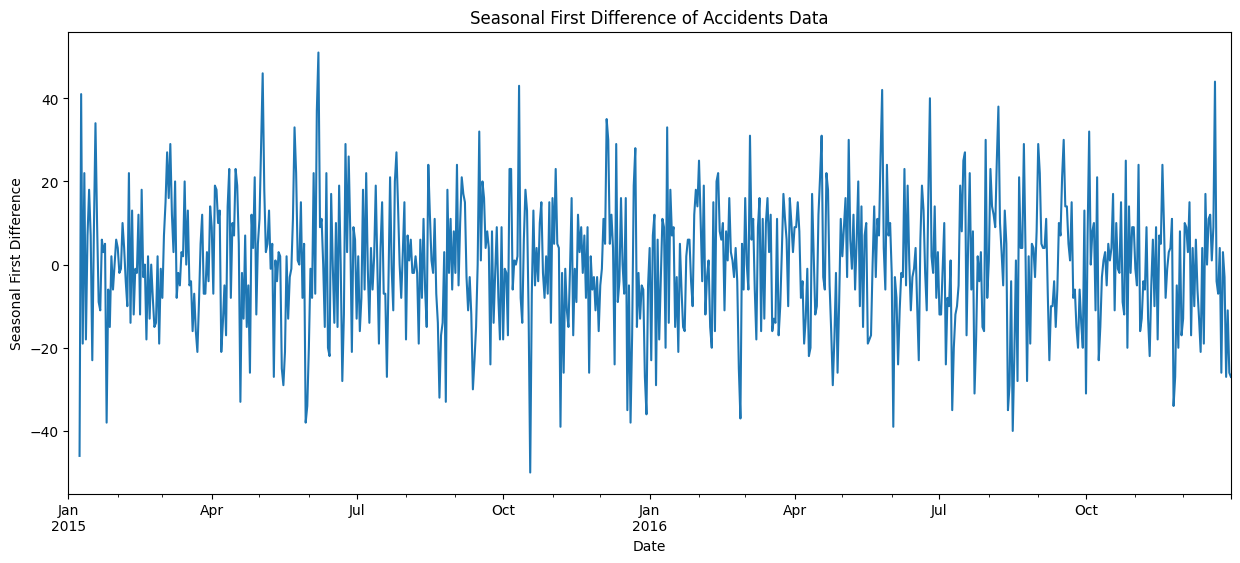

In [42]:
plt.figure(figsize=(15, 6))
accidents['seasonalFirstDifference'].plot()
plt.title('Seasonal First Difference of Accidents Data')
plt.xlabel('Date')
plt.ylabel('Seasonal First Difference')
plt.show()

The Autocorrelation Function (ACF) helps us to identify the moving average (MA) value, while the Partial Autocorrelation Function (PACF) helps us determining the autoregressive (AR) value.

The ACF graph enters the blue shaded region for the first time at lag 4 (see the figure below), indicating that the current value of the time series is assumed to be linearly dependent on its 4 most recent errors. This suggests that we should include an MA term of order 4 (i.e., q=4) in our model.

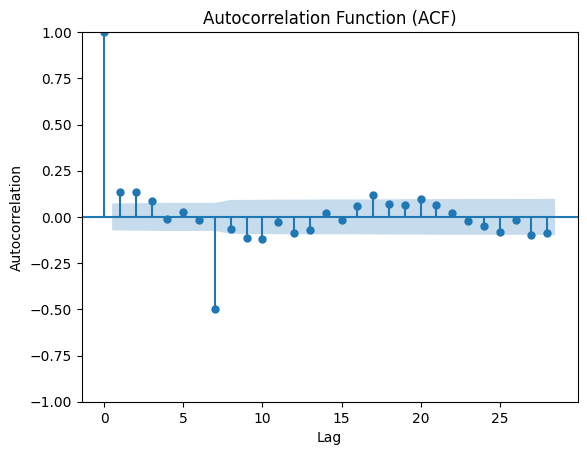

In [43]:
acf = sm.graphics.tsa.plot_acf(accidents['seasonalFirstDifference'].iloc[7:], lags=28)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

Similarly, the PACF graph enters the blue shaded region at lag 3 (see the figure below), indicating that the current value is linearly dependent on the 3 previous values and this suggests including an AR term of order 3 (i.e., p=3) in our model.

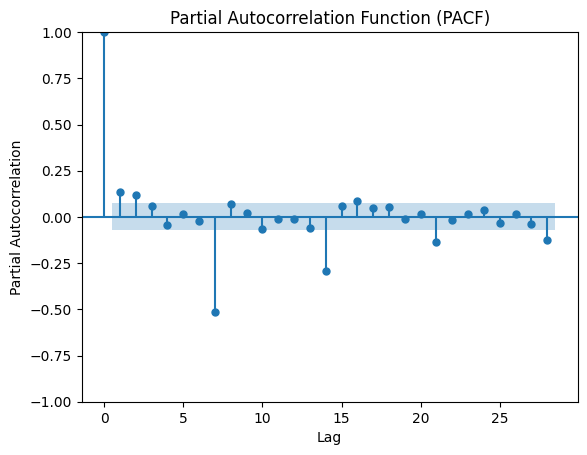

In [44]:
pacf = sm.graphics.tsa.plot_pacf(accidents['seasonalFirstDifference'].iloc[7:], lags=28)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

After determining the values of p, d, q, and s as 3, 1, 4, and 7, respectively, let's create the SARIMA model.

In [45]:
accidents['accidentsCount'] = np.asarray(accidents['accidentsCount']).astype(float)

model = SARIMAX(accidents['accidentsCount'], order = (3, 1, 4), seasonal_order=(3, 1, 4, 7))
results = model.fit(maxiter=1000)

results.summary()

c:\Users\sahin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\sahin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    accidentsCount   No. Observations:                  731
Model:             SARIMAX(3, 1, 4)x(3, 1, 4, 7)   Log Likelihood               -2793.535
Date:                           Wed, 12 Jun 2024   AIC                           5617.070
Time:                                   17:50:59   BIC                           5685.821
Sample:                               01-01-2015   HQIC                          5643.607
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6378      0.191     -3.341      0.001      -1.012      -0.264
ar.L2         -0.4518      0.209     -2.163      0.031      -0.861      -0.042
ar.L3          0.4482      0.186      2.409      0.016       0.083       0.813
ma.L1         -0.1676      0.204     -0.822      0.411      -0.567       0.232
ma.L2         -0.0902      0.046     -1.961      0.050      -0.180    -5.4e-05
ma.L3         -0.8892      0.033    -26.819      0.000      -0.954      -0.824
ma.L4          0.2472      0.184      1.342      0.180      -0.114       0.608
ar.S.L7       -0.7115      0.074     -9.655      0.000      -0.856      -0.567
ar.S.L14       0.4402      0.113      3.893      0.000       0.219       0.662
ar.S.L21       0.8710      0.070     12.450      0.000       0.734       1.008
ma.S.L7       -0.1190      1.498     -0.079      0.937      -3.055       2.817
ma.S.L14      -1.1017      1.326     -0.831      0.406      -3.701       1.497
ma.S.L21      -0.5211      0.380     -1.370      0.171      -1.267       0.224
ma.S.L28       0.7421      1.133      0.655      0.512      -1.478       2.962
sigma2       126.3030    183.588      0.688      0.491    -233.524     486.130
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                24.89
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.26
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date'>

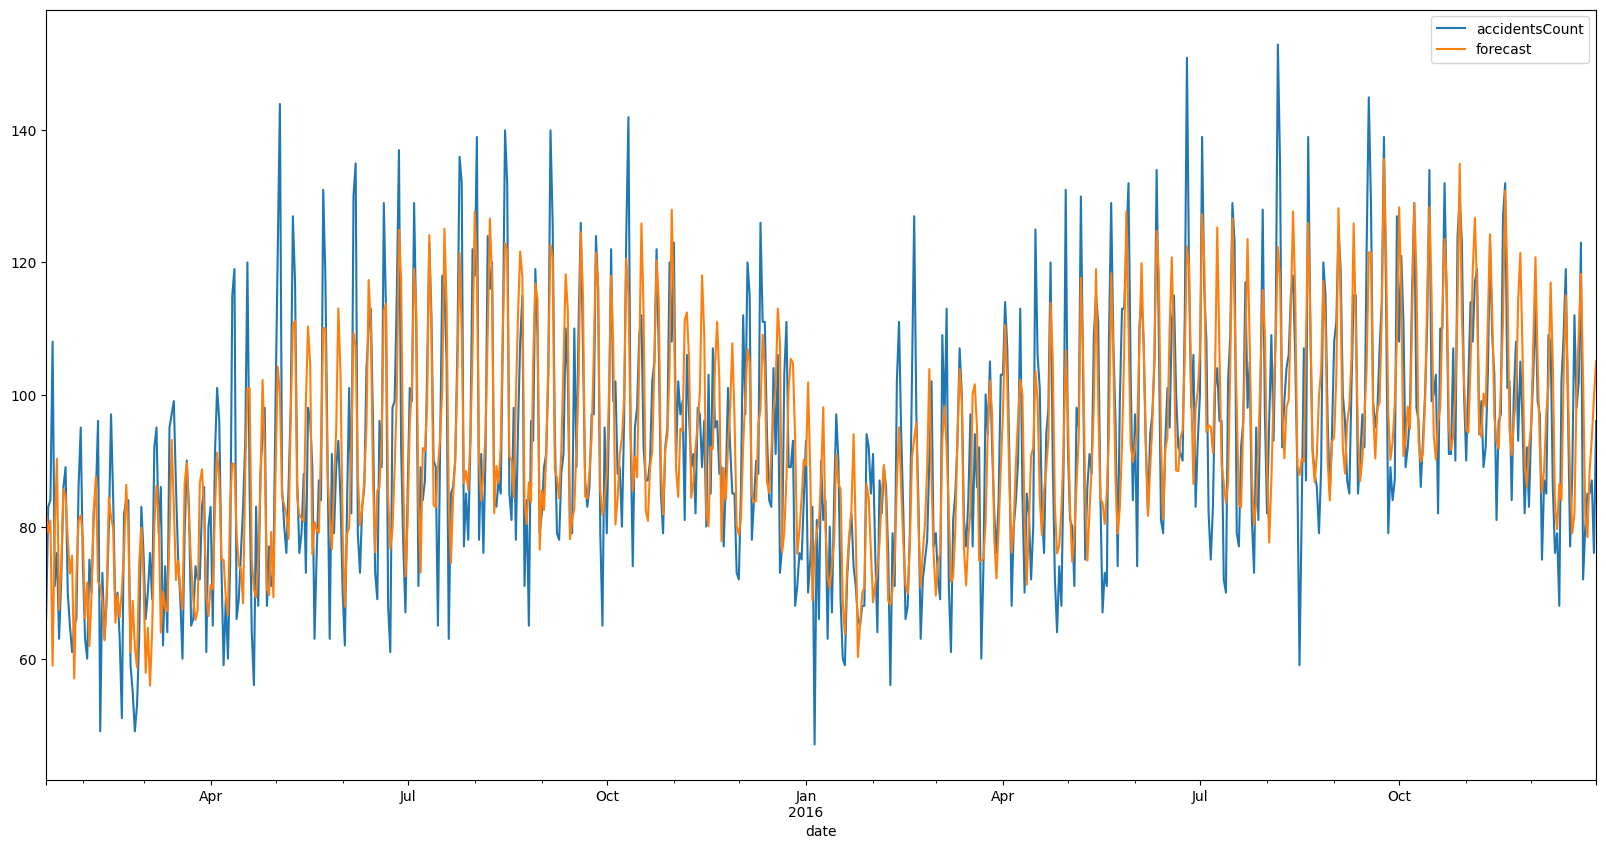

In [46]:
accidents.loc[:, 'forecast'] = results.predict()
accidents[['accidentsCount', 'forecast']][14:].plot(figsize=(20,10))

Now let's find anomalies in our data. I checked the following week after time changes.

In [47]:
time_change = pd.to_datetime(['2015-03-08', '2015-11-01', '2016-03-13', '2016-11-06'])

specific_dates = []
for date in time_change:
    specific_dates.extend(pd.date_range(start=date, periods=7))

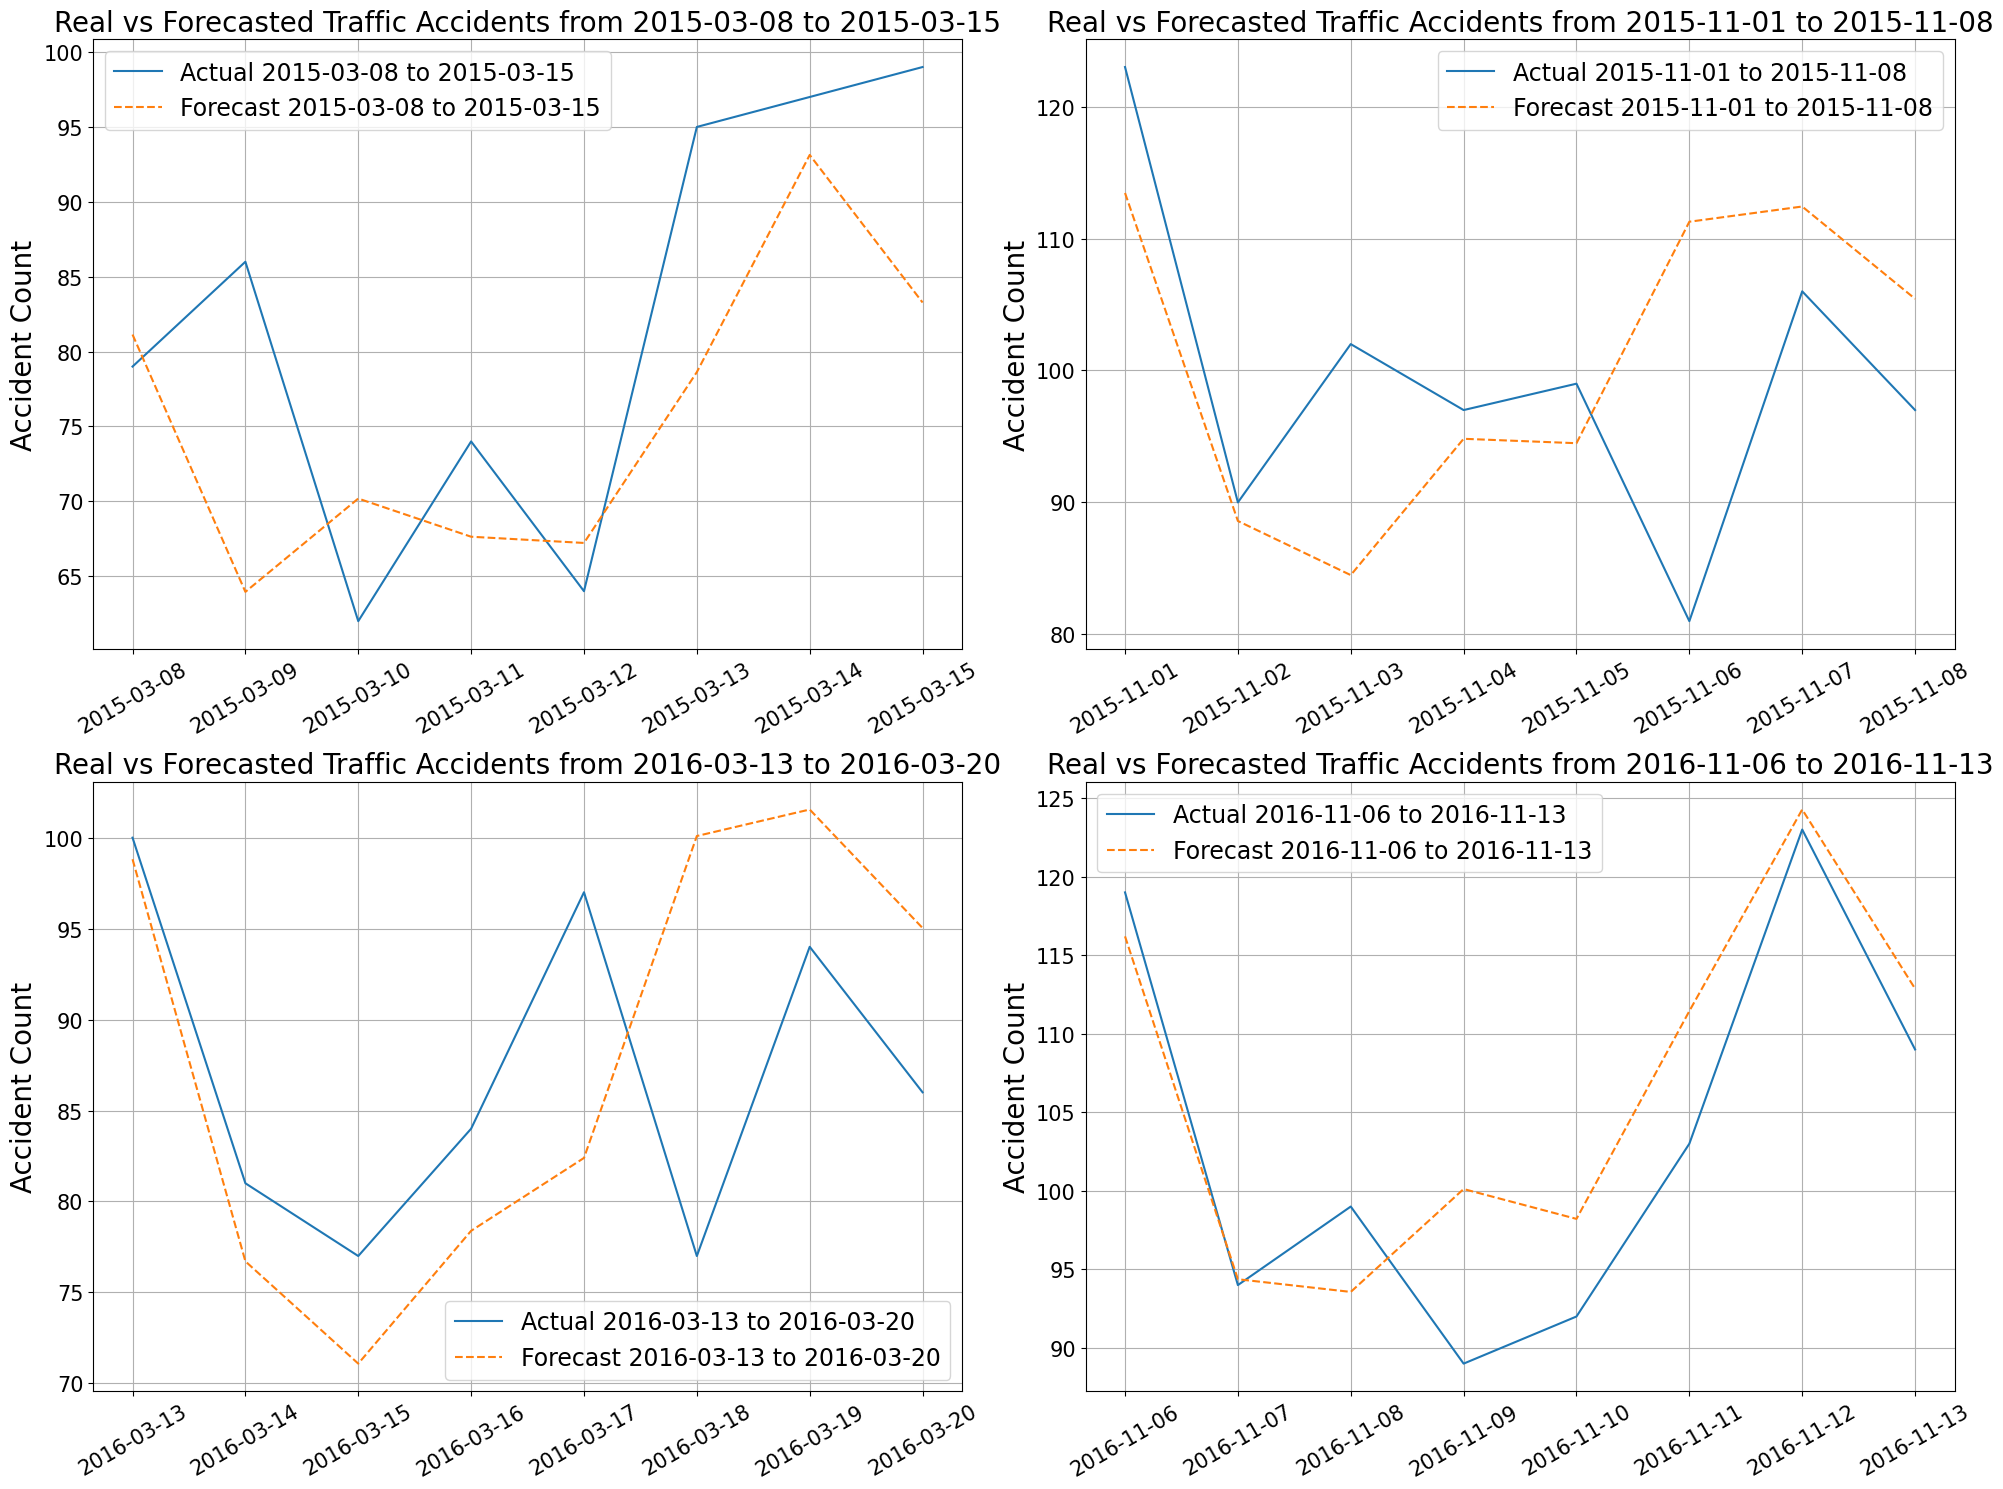

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

for i, date in enumerate(time_change):
    ax = axs[i // 2, i % 2]
    
    start_date = date
    end_date = date + pd.Timedelta(days=7)
    
    ax.plot(accidents.loc[start_date:end_date, 'accidentsCount'], label=f'Actual {start_date.date()} to {end_date.date()}')
    ax.plot(accidents.loc[start_date:end_date, 'forecast'], linestyle='--', label=f'Forecast {start_date.date()} to {end_date.date()}')
    
    ax.set_title(f'Real vs Forecasted Traffic Accidents from {start_date.date()} to {end_date.date()}', fontsize=20)
    ax.set_ylabel('Accident Count', fontsize=20)
    ax.tick_params(axis='x', labelsize=15, rotation=30)
    ax.tick_params(axis='y', labelsize=15) 
    ax.legend(fontsize=17)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [49]:
residuals = pd.DataFrame(results.resid, index=accidents.index)

residuals['z_score'] = (residuals - residuals.mean()) / residuals.std()
threshold = 2
residual_anomalies = residuals[np.abs(residuals['z_score']) > threshold]

unique_anomaly_dates = residual_anomalies.index.unique()
print("Number of anomaly dates:", len(unique_anomaly_dates))

Number of anomaly dates: 27


When performing anomaly detection with a threshold of 2, I identified 27 anomaly days over the span of 2 years, with only one occurring in the week following the time change .

In [50]:
time_change = pd.to_datetime(['2015-03-08', '2015-11-01', '2016-03-13', '2016-11-06'])

specific_dates = []
for date in time_change:
    specific_dates.extend(pd.date_range(start=date, periods=7))

specific_date_anomalies = residual_anomalies[residual_anomalies.index.isin(specific_dates)]
print("Anomalies on specific dates:")
print(specific_date_anomalies)

Anomalies on specific dates:
                   0   z_score
date                          
2015-11-06 -30.27496 -2.349645


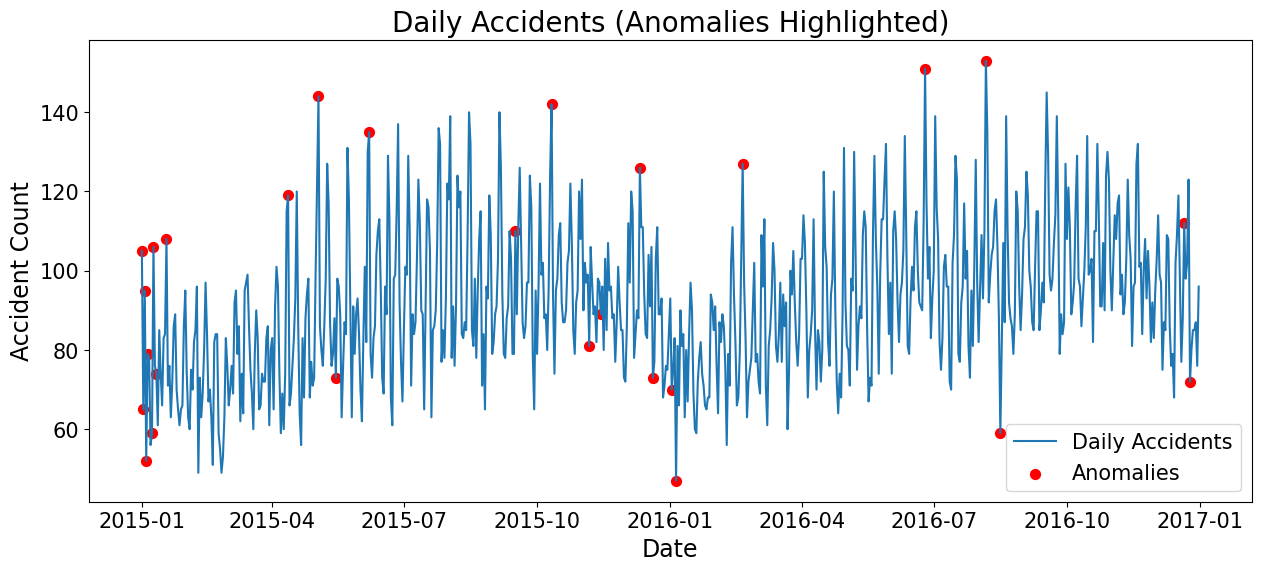

In [51]:
plt.figure(figsize=(15, 6))
plt.plot(accidents['accidentsCount'], label='Daily Accidents')
plt.scatter(residual_anomalies.index, accidents.loc[residual_anomalies.index, 'accidentsCount'], color='red', label='Anomalies', s=50)
plt.title('Daily Accidents (Anomalies Highlighted)', fontsize=20)
plt.xlabel('Date', fontsize=17)
plt.ylabel('Accident Count', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Overall, I did not find any significant anomalies in traffic accidents in the week following the time changes